In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import re
from tqdm import tqdm
from IPython.display import Image, display
from datetime import date, timedelta
import numpy as np
from sklearn import preprocessing
from graph_utils import build_graph

min_max_scaler = preprocessing.MinMaxScaler()

def build_area_seqs(target_area, nks, start='2016-08-01', end='2017-01-01'):
    # 整合到一个文件中
    area_df = pd.DataFrame()
    for name in target_area.parking_name:
        file_name = 'generated/data/seqs/'+name+'_seq.csv'
        file_df = pd.read_csv(file_name)
        file_df['parking'] = nks[name]
        cols = file_df.columns.tolist()
        cols = [cols[0], cols[2], cols[1]]
        file_df = file_df[cols]
        if len(area_df)>0:
            area_df = pd.concat([area_df, file_df])
        else:
            area_df = file_df

    out_bound_indexes = area_df[(area_df['date'] < start) | (area_df['date'] >= end)].index 
    area_df.drop(out_bound_indexes, inplace = True) 
    return area_df.pivot_table('occupy', ['date'], 'parking')


def get_nodes_features(area_df):
    node_f = area_df[['total_space','monthly_fee','building_type']]
    node_f.loc[:,['total_space', 'monthly_fee']] = min_max_scaler.fit_transform(node_f[['total_space', 'monthly_fee']])
    building_type_oneHot = pd.get_dummies(node_f['building_type'])
    node_f = node_f.drop('building_type',axis = 1)
    node_f = node_f.join(building_type_oneHot)
    return node_f

def max_min_scale(raw):
    raw[raw.columns.values] = min_max_scaler.fit_transform(raw[raw.columns.values])
    return raw

def init_data(target_park = '宝琳珠宝交易中心', start='2016-06-02', end='2016-07-07', graph_nodes_max_dis = 0.5):
    basic_info_df = pd.read_csv('generated/data/parkings_info.csv')
    basic_info_df['lat_long'] = list(zip(basic_info_df['latitude'], basic_info_df['longitude']))
    target_area, adj, target_map, nks, kns = build_graph(basic_info_df, target_park, max_dis=graph_nodes_max_dis)
    # target_park_basic_info = basic_info_df.loc[basic_info_df.parking_name == target_park].iloc[0]
    key = nks[target_park]
    node_f = get_nodes_features(target_area)
    seqs_raw = build_area_seqs(target_area, nks, start, end)
    seqs_normal = seqs_raw.fillna(0)
    seqs_normal = max_min_scale(seqs_normal)
    return seqs_normal, adj, node_f, key

In [2]:
import tensorflow as tf
from abc import ABC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, GRU, Flatten, Dense, LeakyReLU
from spektral.layers import GraphConv

l2_reg = 5e-4 / 2  # L2 regularization rate
base=16

class Generator(Model, ABC):

    def __init__(self, adj, nodes_features):
        super(Generator, self).__init__()
        self.adj = adj
        self.nodes_features = nodes_features

        self.dropout = Dropout(dropout)
        if use_gcn:
            self.graph_conv_1 = GraphConv(2*base,
                                          activation='elu',
                                          kernel_regularizer=l2(l2_reg),
                                          use_bias=False)
            self.graph_conv_2 = GraphConv(base,
                                          activation='elu',
                                          kernel_regularizer=l2(l2_reg),
                                          use_bias=False)
        else:
            self.dense_0 = Dense(4*base, activation='relu')
            
        self.dense_1 = Dense(4*base, activation='relu')
        self.dense_2 = Dense(8*base, activation='relu')
        self.gru = GRU(2*base, return_sequences=True)
        self.final_dense = Dense(1, activation='tanh')

    def call(self, seq, training=True):
        s = tf.convert_to_tensor(seq)  # S*N
        
        if use_gcn:
            f = tf.convert_to_tensor(self.nodes_features)  # N*F
            g = tf.convert_to_tensor(self.adj)  # N*N
            c = self.graph_conv_1([f, g])  # N*Cov1
            c = self.graph_conv_2([c, g])  # N*Cov2
            s = tf.matmul(s, c)  # S*N x N*Cov2
        else:    
            s = self.dense_0(s)  # S*D1
            s = self.dropout(s, training=training)

        fc = self.dense_1(s)  # S*D1
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)  # S*D2
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0) 
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)  # S*R
        return self.final_dense(ro)  # S*1


class Discriminator(Model, ABC):

    def __init__(self, adj, nodes_features):
        super(Discriminator, self).__init__()
        self.adj = adj
        self.nodes_features = nodes_features

        self.dropout = Dropout(dropout)
        if use_gcn:
            self.graph_conv_1 = GraphConv(2*base,
                                          activation='elu',
                                          kernel_regularizer=l2(l2_reg),
                                          use_bias=False)
            self.graph_conv_2 = GraphConv(base,
                                          activation='elu',
                                          kernel_regularizer=l2(l2_reg),
                                          use_bias=False)
        else:
            self.dense_0 = Dense(4*base, activation='relu')
            
        self.dense_1 = Dense(4*base, activation='relu')
        self.dense_2 = Dense(8*base, activation='relu')
        self.gru = GRU(2*base, return_sequences=True)
        self.final_dense = Dense(1, activation='tanh')

    def call(self, seq, training=True):
        s = tf.convert_to_tensor(seq)  # S*N
        
        if use_gcn:
            f = tf.convert_to_tensor(self.nodes_features)  # N*F
            g = tf.convert_to_tensor(self.adj)  # N*N
            c = self.graph_conv_1([f, g])  # N*Cov1
            c = self.graph_conv_2([c, g])  # N*Cov2
            s = tf.matmul(s, c)  # S*N x N*Cov2
        else:    
            s = self.dense_0(s)  # S*D1
            s = self.dropout(s, training=training)
            
        fc = self.dense_1(s)  # S*D1
        fc = self.dropout(fc, training=training)
        fc = self.dense_2(fc)  # S*D2
        fc = self.dropout(fc, training=training)

        fc = tf.expand_dims(fc, axis=0)
        ro = self.gru(fc)
        ro = tf.squeeze(ro, axis=0)  # S*R
        return self.final_dense(ro)  # S*1


INFO:tensorflow:Using local port 18964
INFO:tensorflow:Using local port 17523
INFO:tensorflow:Using local port 18662
INFO:tensorflow:Using local port 18246
INFO:tensorflow:Using local port 17177
INFO:tensorflow:Using local port 20852
INFO:tensorflow:Using local port 21508
INFO:tensorflow:Using local port 23418
INFO:tensorflow:Using local port 17338
INFO:tensorflow:Using local port 22999


In [3]:
import os
from tensorflow.keras.optimizers import Adam
from spektral.utils import normalized_laplacian
# from model import Generator, Discriminator
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class Train:
    def __init__(self, seqs, adj, nodes_features, epochs, key):
        self.epochs = epochs
        self.seqs = seqs.astype('float32')
        self.key = key

        self.gen_optimizer = Adam(lr, adam_beta_1)
        self.desc_optimizer = Adam(lr, adam_beta_1)

        self.adj = normalized_laplacian(adj.astype('float32'))
        self.nodes_features = nodes_features.astype('float32')
        self.generator = Generator(self.adj, self.nodes_features)
        self.discriminator = Discriminator(self.adj, self.nodes_features)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def __call__(self, epochs=None ,save_path='generated/'):
        save_path += str(time.time())
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        if epochs is None:
            epochs = self.epochs
            
        time_len = self.seqs.shape[0]
        num_nodes = self.seqs.shape[1]
        total_batch = int(time_len / batch_size)  # 2976/96=31

        time_consumed_total = 0.
        for epoch in range(1, epochs + 1):
            start = time.time()
            total_gen_loss = 0
            total_disc_loss = 0

            for week in range(0, total_batch):
                current_seqs = self.seqs[week*batch_size:week*batch_size + batch_size]
                seqs_noised = current_seqs.copy()
                max_s = current_seqs[self.key].max()
                seqs_noised[self.key] = np.random.normal(max_s / 2.0, max_s / 10.0,
                                                         size=(current_seqs.shape[0])).astype('float32')
                # current_seqs.plot(figsize=(20,5))
                # seqs_noised.plot(figsize=(20,5))
                gen_loss, disc_loss = self.train_step(current_seqs, seqs_noised)
                total_gen_loss += gen_loss
                total_disc_loss += disc_loss

            time_consumed = time.time() - start
            time_consumed_total += time_consumed
            time_consumed_agv = time_consumed_total / epoch
            epochs_last = epochs - epoch
            estimate_time_last = epochs_last * time_consumed_agv
            print('epoch {}({})/{}({}) - gen_loss = {}, disc_loss = {}, estimated to finish: {}'
              .format(epoch, round(time.time() - start, 2),
                      epochs, round(time_consumed_total, 2),
                      round(float(total_gen_loss / total_batch), 5),
                      round(float(total_disc_loss / total_batch), 5),
                      round(estimate_time_last, 2)))
            
            if epoch % save_week_interval == 0:
                self.compare_plot('week_'+str(epoch), save_path, int(total_batch/2)*7)
            if epoch % save_all_interval == 0:
                self.compare_plot('all_'+str(epoch), save_path, 0, total_batch) 
        self.save_model(save_path, time_consumed_total)

    @tf.function
    def train_step(self, seqs, seqs_noised):
        with tf.GradientTape(persistent=True) as tape:
            real_output = self.discriminator(seqs)  # 评价高
            generated = self.generator(seqs_noised)
            left = tf.slice(seqs, [0, 0], [batch_size, self.key])
            right = tf.slice(seqs, [0, self.key + 1], [batch_size, -1])
            combined = tf.concat([left, generated, right], 1)
            generated_output = self.discriminator(combined)  # 初始评价低

            loss_g = self.generator_loss(self.cross_entropy, generated_output)
            loss_d = self.discriminator_loss(self.cross_entropy, real_output, generated_output)

        grad_gen = tape.gradient(loss_g, self.generator.trainable_variables)
        grad_disc = tape.gradient(loss_d, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(grad_gen, self.generator.trainable_variables))
        self.desc_optimizer.apply_gradients(zip(grad_disc, self.discriminator.trainable_variables))

        return loss_g, loss_d

    def generate(self, real_seqs):
        seqs_replace = real_seqs.copy()
        max_s = seqs_replace[self.key].max()
        seqs_replace[self.key] = np.random.normal(max_s / 2.0, max_s / 10.0, size=(seqs_replace.shape[0])).astype(
            'float32')
        gen_data = self.generator(seqs_replace, training=False)
        return pd.DataFrame(gen_data.numpy())
    
    @staticmethod
    def discriminator_loss(loss_object, real_output, fake_output):
        real_loss = loss_object(tf.ones_like(real_output), real_output)
        fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @staticmethod
    def generator_loss(loss_object, fake_output):
        return loss_object(tf.ones_like(fake_output), fake_output)
    
    def compare_plot(self, name, save_path, start_day=0, week=1):
        fig, ax = subplots()
        fig.set_figheight(8)
        fig.set_figwidth(20)
        real_seqs = self.seqs[start_day:start_day+batch_size*week]
        generated_seqs = []
        for w in range(week):
            generated_seq = self.generate(real_seqs[start_day*w:start_day*w+batch_size])
            if len(generated_seqs) == 0:
                generated_seqs = generated_seq
            else:
                generated_seqs =  generated_seqs.append(generated_seq, ignore_index=True)
        generated_seqs = max_min_scale(generated_seqs)
        all_seqs = pd.concat([pd.DataFrame(real_seqs[self.key].values), generated_seqs], axis=1)
        all_seqs.plot(ax=ax)
        n=2
        ax.legend(['real'+str(w) for w in range(1,n)]+['gen'+str(w) for w in range(1,n)]);
        fig.savefig(save_path+"/compare_" + name + ".png")
        plt.close()
    
    def load_model(self, save_path):
        """
        ...
        """
        self.generator.load_weights(save_path + '/model_generator_weight')
        self.discriminator.load_weights(save_path + '/model_discriminator_weight')
        print('models from ' + save_path + ' recovered. ')

    def save_model(self, save_path, time_consumed_total):
        """
        ...
        """
        self.generator.save_weights(save_path + '/model_generator_weight')
        self.discriminator.save_weights(save_path + '/model_discriminator_weight')
        print('models saved into path: ' + save_path + ', total time consumed: %s' % time_consumed_total)

In [19]:
def start_train(target_park='宝琳珠宝交易中心', start='2016-06-02', end='2016-07-07'):
    seqs_normal, adj, node_f, key = init_data(target_park, start, end)
    seqs_normal[2].plot(figsize=(20,10))
    # seqs_normal.plot(figsize=(30,15))
    name=target_park+'_GCN_'+str(use_gcn)
    print('Start '+name, seqs_normal.shape, key)
    save_path='generated/'+str(epochs)
    #train = Train(seqs_normal, adj, node_f, epochs, key)
    #train(epochs, save_path+'/'+name+'_')
    #print('Finished '+name)
    #return train

def resume_train(train, epochs=1000):
    name='Resume_GCN_'+str(use_gcn)
    save_path='generated/'+str(epochs)
    train(epochs, save_path+'/'+name+'_')
    print('Finished '+name)
    return train

In [20]:
batch_size = 96*7
lr = 0.0001
adam_beta_1 = 0.5
epochs=10000
save_week_interval = 10
save_all_interval = 50
dropout = 0.5
alpha = 0.2

Start 宝琳珠宝交易中心_GCN_False (4032, 3) 1


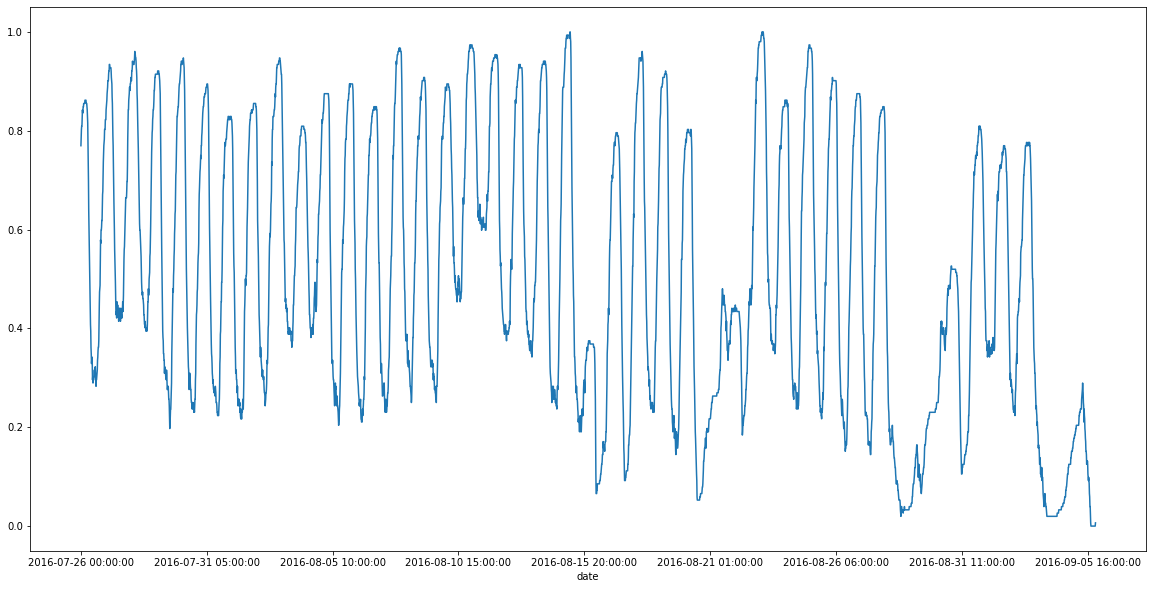

In [21]:
use_gcn=False
no_gcn_train = start_train('宝琳珠宝交易中心', '2016-07-26', '2016-09-06')

In [ ]:
use_gcn=True
no_gcn_train = start_train('宝琳珠宝交易中心', '2016-07-26', '2016-09-06')